In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import random

In [2]:
params = {
    'num_nodes' : 50,
    'nearest_neighbors' : 10,
    'rewiring_probability' : 0.01,
    'initial_infected':4,
    'initial_recovered':0,
    'timesteps':200,
    'infection_rate':0.1,
    'recovery_rate':0.005,

    
}

G = nx.watts_strogatz_graph(params['num_nodes'], params['nearest_neighbors'], params['rewiring_probability'])

# Visualization


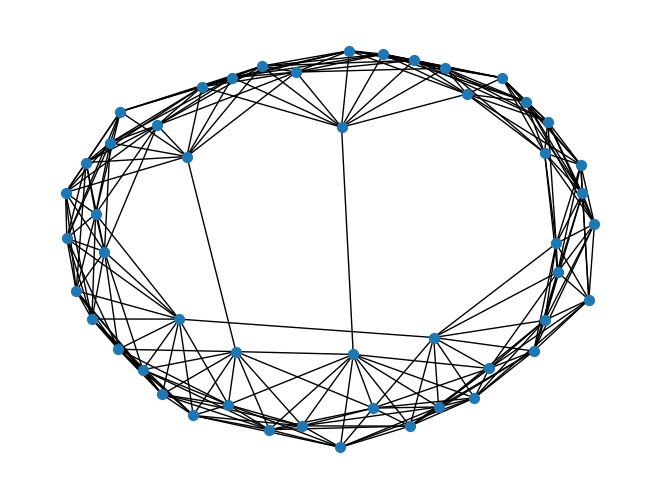

In [3]:
nx.draw(G, with_labels=False, node_size=50)
plt.show()

## Network Metrics

In [4]:
print(f'Number of Edges:{len(G.edges())}')
print(f'Number of Nodes:{len(G.nodes())}')

Number of Edges:250
Number of Nodes:50


In [5]:
betweenness = nx.betweenness_centrality(G)
print(f"Average Betweenness Centrality = {np.mean(list(betweenness.values()))}")

Average Betweenness Centrality = 0.03251700680272109


In [6]:
clustering_coefficient = nx.average_clustering(G)
print(f"Clustering Coefficient = {clustering_coefficient}")

Clustering Coefficient = 0.6402626262626266


In [7]:
print(f"Average Path Length = {nx.average_shortest_path_length(G)}")

Average Path Length = 2.5608163265306123


In [8]:
for node in G.nodes:
    G.nodes[node]['state'] = 0

initial_infections = random.sample(list(G.nodes), params['initial_infected'])
for node in initial_infections:
    G.nodes[node]['state'] = 1

# Randomly set a few individuals as recovered (state = 2)
remaining_nodes = list(set(G.nodes) - set(initial_infections))
initial_recoveries = random.sample(remaining_nodes, params['initial_recovered'])
for node in initial_recoveries:
    G.nodes[node]['state'] = 2


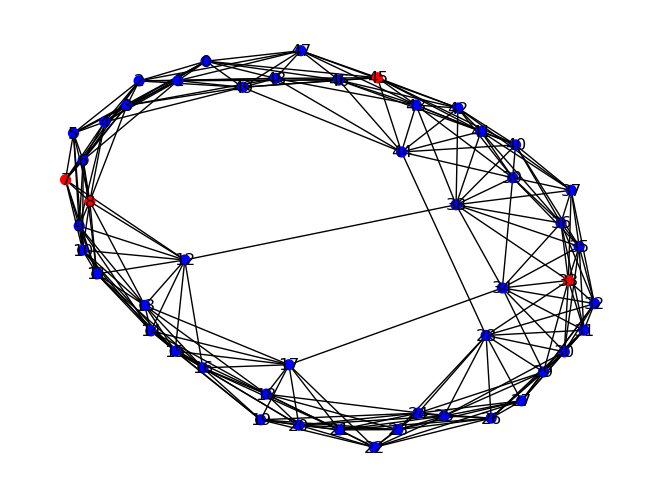

In [9]:
color_map = {0: 'blue', 1: 'red', 2: 'green'}
node_colors = [color_map[G.nodes[node]['state']] for node in G.nodes]
nx.draw(G, node_color=node_colors, with_labels=True, node_size=50)
plt.show()

## Simulating an Epidemic spread across the network

In [10]:
def simulate_step(G, params):
    new_infections = []
    new_recoveries = []

    for node in G.nodes:
        if G.nodes[node]['state'] == 1:  # Infected
            # Check if the infected individual recovers
            if random.random() < params['recovery_rate']:
                new_recoveries.append(node)
            # Spread the disease to susceptible neighbors
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['state'] == 0 and random.random() < params['infection_rate']:
                    new_infections.append(neighbor)
    
    # Update states
    for node in new_infections:
        G.nodes[node]['state'] = 1
    for node in new_recoveries:
        G.nodes[node]['state'] = 2


In [11]:
susceptible_counts = []
infected_counts = []
recovered_counts = []


In [12]:
for t in range(params['timesteps']):
    susceptible_counts.append(sum(1 for n in G.nodes if G.nodes[n]['state'] == 0))
    infected_counts.append(sum(1 for n in G.nodes if G.nodes[n]['state'] == 1))
    recovered_counts.append(sum(1 for n in G.nodes if G.nodes[n]['state'] == 2))
    
    simulate_step(G, params)


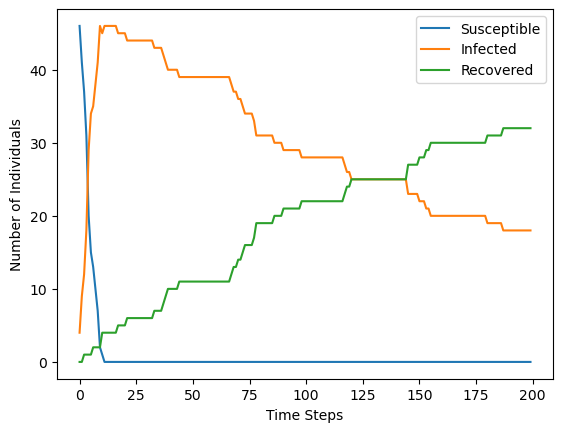

In [13]:
plt.plot(susceptible_counts, label='Susceptible')
plt.plot(infected_counts, label='Infected')
plt.plot(recovered_counts, label='Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()


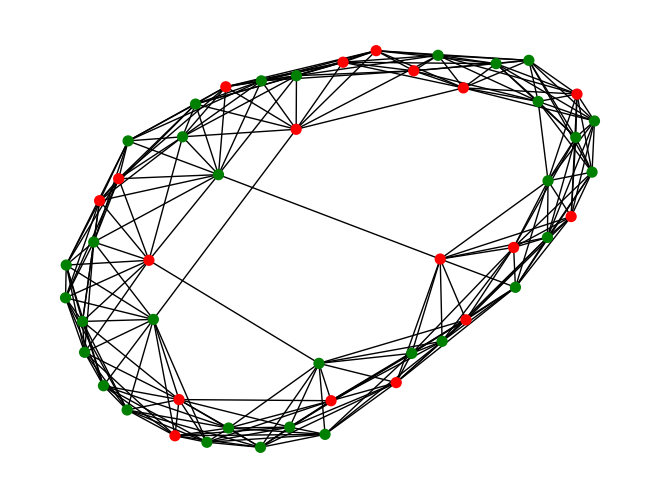

In [14]:
color_map = {0: 'blue', 1: 'red', 2: 'green'}
node_colors = [color_map[G.nodes[node]['state']] for node in G.nodes]
nx.draw(G, node_color=node_colors, with_labels=False, node_size=50)

plt.show()

## Avg number of nodes infected by every infected node

In [15]:
def estimate_R0(G, params, num_trials=100):
    R0_estimates = []
    
    for _ in range(num_trials):
        # Reset node states
        for node in G.nodes:
            G.nodes[node]['state'] = 0
        # Infect a single random node
        initial_infected = random.choice(list(G.nodes))
        G.nodes[initial_infected]['state'] = 1
        
        # Simulate one step to count new infections
        new_infections = 0
        for neighbor in G.neighbors(initial_infected):
            if G.nodes[neighbor]['state'] == 0 and random.random() < params['infection_rate']:
                new_infections += 1
        
        R0_estimates.append(new_infections)
    
    return np.mean(R0_estimates)


In [16]:
r0 = estimate_R0(G,params )

In [17]:
print(f"Avg number of infections produced by one node: {r0}")

Avg number of infections produced by one node: 1.1


## Number of infected nodes at the end

In [18]:
def final_infected(G, params):
#    for node in G.nodes:
#        G.nodes[node]['state'] = 0

#    initial_infections = random.sample(list(G.nodes), params['initial_infected'])
#    for node in initial_infections:
#        G.nodes[node]['state'] = 1

    for _ in range(params['timesteps']):
        simulate_step(G, params)
    
    final_infected_number = sum(1 for n in G.nodes if G.nodes[n]['state'] == 2)  # Total recovered (i.e., were infected)
    return final_infected_number


In [19]:
final_infected(G,params)

35

## Time Series Plot

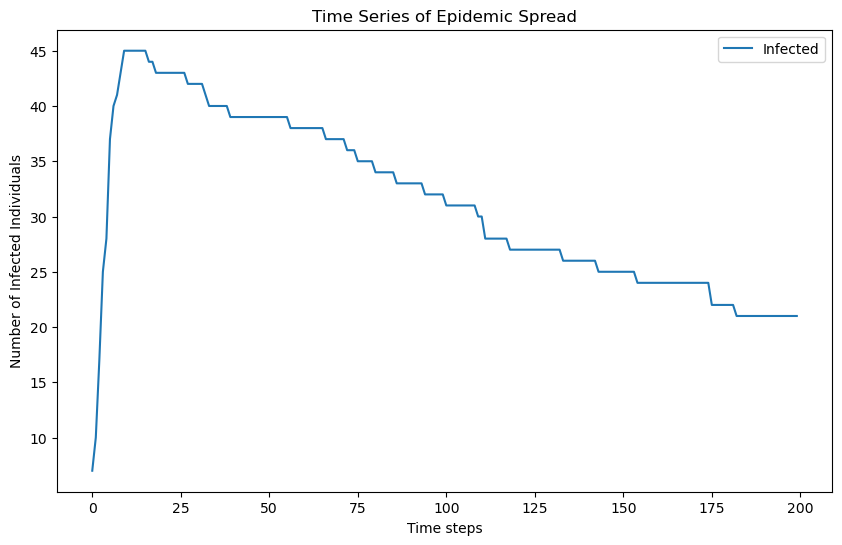

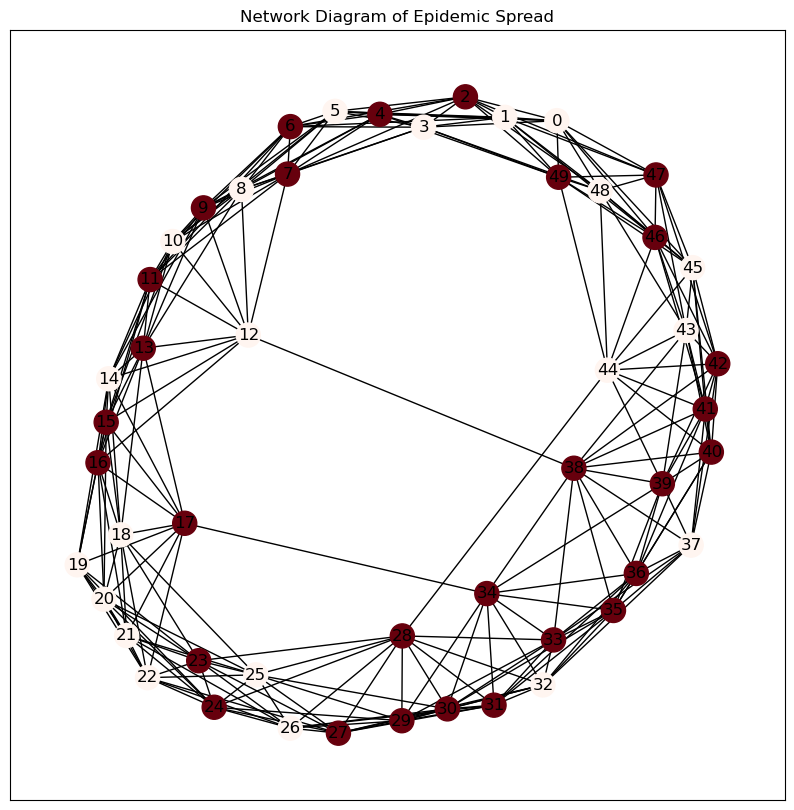

In [21]:


def simulate_and_plot_epidemic(G, params):
   
    for node in G.nodes:
        G.nodes[node]['state'] = 0

    initial_infections = random.sample(list(G.nodes), params['initial_infected'])
    for node in initial_infections:
        G.nodes[node]['state'] = 1

    infected_counts = []

    for t in range(params['timesteps']):
        simulate_step(G, params)
        infected_count = sum(1 for n in G.nodes if G.nodes[n]['state'] == 1)
        infected_counts.append(infected_count)

    return infected_counts

infected_counts = simulate_and_plot_epidemic(G, params)

plt.figure(figsize=(10, 6))
plt.plot(infected_counts, label='Infected')
plt.xlabel('Time steps')
plt.ylabel('Number of Infected Individuals')
plt.title('Time Series of Epidemic Spread')
plt.legend()
plt.show()

# Network visualization
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_color=[G.nodes[n]['state'] for n in G.nodes], cmap=plt.cm.Reds, with_labels = True)
plt.title('Network Diagram of Epidemic Spread')
plt.show()
